In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
roc_curve, roc_auc_score, classification_report, precision_recall_curve, average_precision_score)

%matplotlib inline

In [27]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [28]:
# Quick summary statistics and zero-counts (columns where 0 indicates missing)
cols_possible_zero_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']


In [29]:

print('Data types:')
print(df.dtypes)


Data types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [30]:

zero_counts = {c: int((df[c] == 0).sum()) for c in cols_possible_zero_missing}
print('\nZero counts (likely missing):', zero_counts)



Zero counts (likely missing): {'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11}


In [31]:

print('\nNull counts:')
print(df.isnull().sum())

print('\nDescriptive statistics:')
display(df.describe().transpose())



Null counts:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [32]:

print('\nOutcome class counts:')
print(df['Outcome'].value_counts())
print('\nOutcome proportions:')
print(df['Outcome'].value_counts(normalize=True).round(3))

print('\nShape:', df.shape)
print('Columns:', list(df.columns))




Outcome class counts:
Outcome
0    500
1    268
Name: count, dtype: int64

Outcome proportions:
Outcome
0    0.651
1    0.349
Name: proportion, dtype: float64

Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [33]:
# Convert known-zero placeholders to NaN and show missingness + correlation
cols_missing_zero = cols_possible_zero_missing

df_clean = df.copy()
df_clean[cols_missing_zero] = df_clean[cols_missing_zero].replace(0, np.nan)

print('Missing after replacing zeros:')
print(df_clean[cols_missing_zero].isnull().sum())

print('\nDescribe (with NaNs unchanged):')
display(df_clean.describe().transpose())


Missing after replacing zeros:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Describe (with NaNs unchanged):


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [34]:
# Separate help imputing function for insulin
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class BiologicallySaneImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, seed=42):
        self.target_col = target_col
        self.seed = seed
        # Biologically grounded distribution plan
        self.distribution_plan = [
            (0, 25, 0.156), (25, 50, 0.247), (50, 100, 0.273),
            (100, 150, 0.143), (150, 200, 0.078), (200, 300, 0.059),
            (300, 400, 0.026), (400, 600, 0.013), (600, 850, 0.005)
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        np.random.seed(self.seed)  # Reproducibility
        
        # 0. Treat extreme hyperinsulinemia as unreliable
        extreme_mask = X[self.target_col] > 400
        X.loc[extreme_mask, self.target_col] = np.nan
        
        # 1. Identify NaNs (original zeros + extreme outliers)
        mask = X[self.target_col].isnull()
        num_missing = mask.sum()

        if num_missing > 0:
            simulated_values = []

            # 2. Log-uniform biological simulation
            for low, high, prob in self.distribution_plan:
                count = int(prob * num_missing)
                low_adj = max(low, 1)  # avoid log(0)
                chunk = np.exp(
                    np.random.uniform(np.log(low_adj), np.log(high), size=count)
                )
                simulated_values.extend(chunk)

            # 3. Fix rounding drift
            diff = num_missing - len(simulated_values)
            if diff > 0:
                simulated_values.extend(
                    np.exp(np.random.uniform(np.log(25), np.log(75), size=diff))
                )
            elif diff < 0:
                simulated_values = simulated_values[:num_missing]

            # 4. Inject ONLY into missing/extreme rows
            np.random.shuffle(simulated_values)
            X.loc[mask, self.target_col] = simulated_values

        return X


# Apply the biologically sane imputation
insulin_sim = BiologicallySaneImputer(target_col='Insulin')
df_clean = insulin_sim.transform(df_clean)

# Verification checks
print(f"Check: Values < 60 are still present: {len(df_clean[df_clean['Insulin'] < 60])}")
print(f"Check: Any remaining NaNs? {df_clean['Insulin'].isnull().sum()}")
print(f"Check: Extreme values > 600: {(df_clean['Insulin'] > 600).sum()}")


Check: Values < 60 are still present: 250
Check: Any remaining NaNs? 0
Check: Extreme values > 600: 1


In [35]:
#Inspect the insulin column
try:
    data = df_clean
except NameError:
    data = df
ins = pd.to_numeric(data['Insulin'], errors='coerce')

# thresholds
below_thresholds = [50, 100]
above_thresholds = list(range(300, 801, 100))  # 300,400,...,800

counts = {}
for t in below_thresholds:
    counts[f'below_{t}'] = int((ins < t).sum())

counts['ge_100'] = int((ins >= 100).sum())
counts['ge_200'] = int((ins >= 200).sum())

for t in above_thresholds:
    counts[f'ge_{t}'] = int((ins >= t).sum())

# diagnostics
total_nonnull = int(ins.notnull().sum())
print(f"Total non-null Insulin values: {total_nonnull}")
for k, v in counts.items():
    print(f"{k}: {v}")


df_clean['Insulin'].describe()



Total non-null Insulin values: 768
below_50: 197
below_100: 413
ge_100: 355
ge_200: 108
ge_300: 34
ge_400: 6
ge_500: 4
ge_600: 1
ge_700: 1
ge_800: 0


count    768.000000
mean     113.166381
std       90.456125
min        1.068503
25%       49.000000
50%       92.631105
75%      155.000000
max      794.692777
Name: Insulin, dtype: float64

In [36]:
from sklearn.impute import SimpleImputer
# Replace NaNs in other columns using median imputation
cols_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

# Run the median imputer on these columns
median_imputer = SimpleImputer(strategy='median')
df_clean[cols_to_impute] = median_imputer.fit_transform(df_clean[cols_to_impute])

print("Remaining NaNs in the dataset:")
print(df_clean.isnull().sum())


Remaining NaNs in the dataset:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


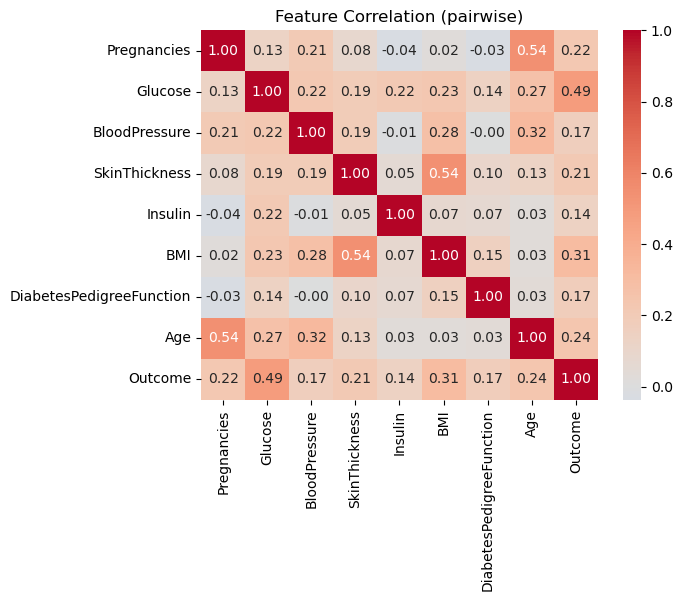

In [37]:

# Correlation heatmap (uses pairwise complete observations)
#plt.figure(figsize=(9,7))
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation (pairwise)')
plt.show()


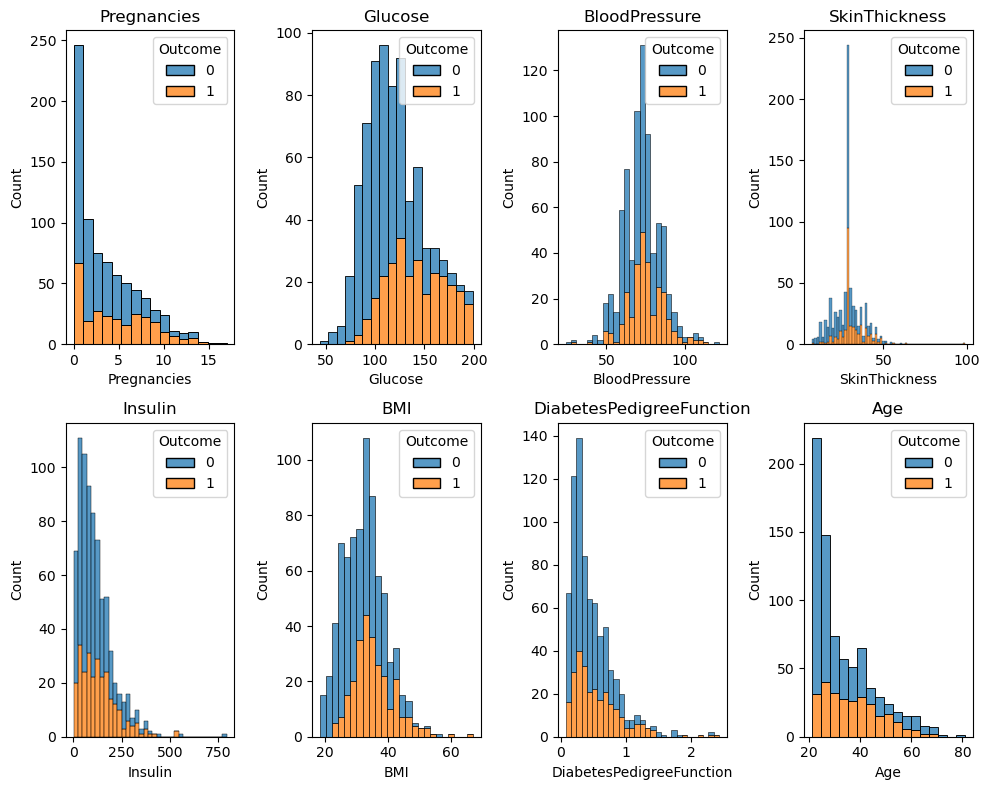

In [38]:
#distributions by Outcome
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

fig, axes = plt.subplots(2,4, figsize=(10,8
))
for ax, feat in zip(axes.flatten(), features):
    sns.histplot(data=df_clean, x=feat, hue='Outcome', multiple='stack', kde=False, ax=ax)
    ax.set_title(feat)
plt.tight_layout()
plt.show()


In [39]:
df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,113.166381,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,90.456125,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,1.068503,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,49.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,92.631105,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,794.692777,67.100000,2.420000,81.000000,1.000000


In [40]:
# Split data
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features shape: (768, 8)
Target distribution:
Outcome
0    500
1    268
Name: count, dtype: int64


In [41]:
# Scale features (mostly for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
def evaluate_model(name, model, X, y_true):

    y_pred = model.predict(X)
    print(f"--- {name} Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("-" * 30 + "\n")


In [43]:

# --- 1. Random Forest ---
# Random Forest is tree-based and doesn't strictly require scaling
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model("Random Forest model", rf, X_test, y_test)

# --- 2. Logistic Regression (FIXED) ---
# MUST use X_train_scaled and X_test_scaled for accurate coefficients
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)  
evaluate_model("Logistic Regression model", lr, X_test_scaled, y_test) 

--- Random Forest model Evaluation ---
Accuracy: 0.7143

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154

------------------------------

--- Logistic Regression model Evaluation ---
Accuracy: 0.7208

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       100
           1       0.62      0.54      0.57        54

    accuracy                           0.72       154
   macro avg       0.69      0.68      0.68       154
weighted avg       0.71      0.72      0.72       154

------------------------------



In [45]:
from xgboost import XGBClassifier

# 1. Initialize the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Fit the model
xgb_model.fit(X_train, y_train)

# 3. Evaluate using your existing function
evaluate_model("XGBoost", xgb_model, X_test, y_test)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
%pip install xgboost